In [ ]:
## lets get creative!

In [1]:
import numpy as np
from numpy import random
import scipy.integrate as integrate
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib as mpl


### Structural Balance Dynamics

In [2]:
#####################################################
###### set the initial condition parameters #########
#####################################################

N = 100     # number of nodes in the network

N_blue = int(N/2)  #number 'blue' nodes, half are blue
N_red = int(N/2)   #number 'red' nodes, half are red
tags = np.hstack((np.ones(int(N_red)), 2*np.ones(int(N_blue))))


# parameter settings
di = 0.7      # d_{in}
do = 0.7      # d_{out}
pip = 0.7     # p_{in}^+
pop = 0.35    # p_{out}^+


In [3]:
############################################
#### construct the initial random matrix ##########
############################################

prob_collab_br_rb = pop                     #probability of a blue and red node collaborating
prob_collab_bb_rr = pip                    #probability of a blue and blue node collaborating (or red-to-red)
prob_fight_br_rb = 1-pop                    #probability of a blue and red node fighting
prob_fight_bb_rr = 1-pip                     #probability of a blue and blue node fighting (or red-to-red fighting)
Adj = np.empty((N,N))
Adj_bb = np.zeros((N_blue,N_blue))            #blue-to-blue connectivity
Adj_rr = np.zeros((N_red,N_red))              #red-to-red connectivity
Adj_br = np.zeros((N_blue,N_red))             #blue-to-red connectivity
Adj_rb = np.zeros((N_red,N_blue))             #red-to-blue connectivity


#generate Adj_bb
num_upper_diag =int((N_blue**2-N_blue)/2)     #checked
shuffle_list  = random.permutation(num_upper_diag)        #checked
num_collab = int(prob_collab_bb_rr*di*(num_upper_diag)) 
num_fight = int(prob_fight_bb_rr*di*(num_upper_diag))  
v = np.zeros(num_upper_diag)
v[shuffle_list[0:num_collab]] = 1
v[shuffle_list[num_collab:num_collab+num_fight]] = -1
Adj_bb[np.triu_indices(N_blue, k=1)] = v
Adj_bb = Adj_bb + np.transpose(Adj_bb) + 0*np.diag(np.ones(N_blue))

#generate Adj_rr
num_upper_diag = int((N_red**2-N_red)/2)
shuffle_list  = random.permutation(num_upper_diag)
num_collab = int(prob_collab_bb_rr*di*(num_upper_diag))
num_fight = int(prob_fight_bb_rr*di*(num_upper_diag))
v = np.zeros(num_upper_diag)
v[shuffle_list[0:num_collab]] = 1
v[shuffle_list[num_collab:num_collab+num_fight]] = -1
Adj_rr[np.triu_indices(N_red, k=1)] = v
Adj_rr = Adj_rr + np.transpose(Adj_rr) + 0*np.diag(np.ones(N_red))

#generate Adj_br
shuffle_list = random.permutation(N_blue*N_red)
num_collab = int(prob_collab_br_rb*do*N_blue*N_red)
num_fight = int(prob_fight_br_rb*do*N_blue*N_red)
v = np.zeros(N_blue*N_red)
v[shuffle_list[0:num_collab]] = 1
v[shuffle_list[num_collab: num_collab+num_fight]] = -1
row, col = np.indices((N_blue,N_red))
row = np.reshape(row,(1,-1))
col = np.reshape(col,(1,-1))
Adj_br[row,col] = v

# generate Adj_rb
Adj_rb = np.transpose(Adj_br)

# put together the initial matrix Adj
Adj = np.vstack([np.hstack([Adj_bb, Adj_br]), np.hstack([Adj_rb, Adj_rr])])

In [4]:
#####################################################
### Structural balance differential equation ########
#####################################################

def  structural_balance(t,A_vec):
            A = np.reshape(A_vec,(N,N))
            A_sq = np.matmul(A,A)
            dAdt = np.reshape(A_sq,(1,-1))[0]
            return dAdt               

In [5]:
#############################################
###### do the simulation ####################
#############################################

Adj_vec = 0.01*np.reshape(Adj,(1,-1))[0]
t0, t1 = 0, 5
t = np.linspace(t0,t1,1000)
y0 = Adj_vec
y = np.zeros((len(t), len(y0)))
y[0, :] = y0

r = integrate.ode(structural_balance).set_integrator("dopri5") 
r.set_initial_value(y0,t0)

for i in range(1, t.size):
    y[i,:] = r.integrate(t[i])  
    if not r.successful():
       raise RuntimeError("Could not integrate, simulation complete")  #Once the solutions become unbound the simulation will end


/home/mmtree/.local/lib/python3.6/site-packages/scipy/integrate/_ode.py:1177: UserWarning: dopri5: step size becomes too small
  self.messages.get(istate, unexpected_istate_msg)))


RuntimeError: Could not integrate, simulation complete

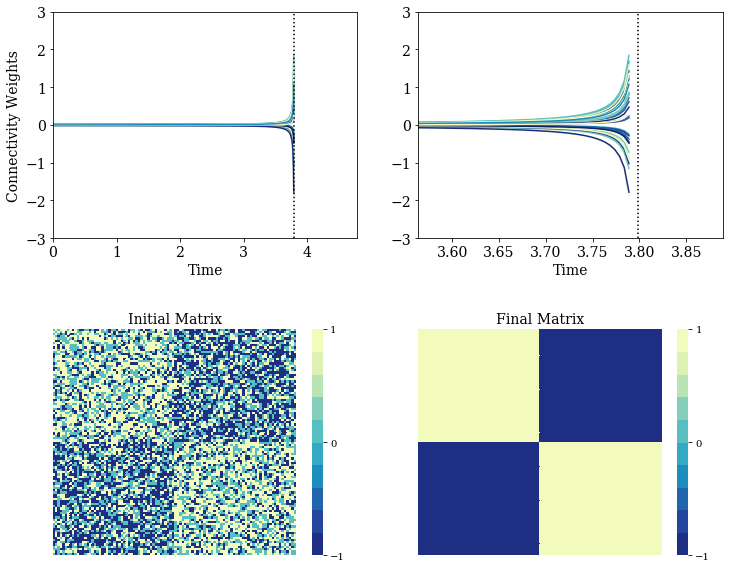

In [40]:
y = y[0:i-1,:]
t = t[0:i-1]
#################################################
#### Plot evolution of weights over time ########
#################################################
f = plt.figure(figsize=(12, 10))
sns.set_style({'font.family':'serif', 'font.serif':'Times New Roman'})
cmap = cm.get_cmap('YlGnBu')

ax1 = f.add_subplot(2, 2, 1)
ax2 = f.add_subplot(2, 2, 2)

for ii in range(36):
    n = random.randint(1,N*N)
    c = cmap(float(random.randint(36))/(36))
    ax1.plot(t, y[:,n], color=c, label=repr(ii))
    ax2.plot(t, y[:,n], color=c, label=repr(ii))
    
xcoords = [t[-1]+0.01]
colors = ['k']

for xc,c in zip(xcoords,colors):
    ax1.axvline(x=xc, c=c,linestyle = ':')
    ax2.axvline(x=xc, c=c,linestyle = ':')

ax1.set_ylim((-3.0, 3.0))
ax1.set_xlim((0, t[-1]+1))    
ax1.set_ylabel('Connectivity Weights',fontsize=14)
ax1.set_xlabel('Time',fontsize=14)
ax1.tick_params(labelsize=14)
ax1.grid(0)

ax2.set_ylim((-3.0, 3.0))
ax2.set_xlim((t[np.int(0.94*t.size)],t[-1]+0.1))  
ax2.set_xlabel('Time',fontsize=14)
ax2.tick_params(labelsize=14)
ax2.grid(0)


ax3 = f.add_subplot(2, 2, 3)
sns.set_style({'font.family':'serif', 'font.serif':'Times New Roman'})
pal = sns.color_palette(reversed(sns.color_palette("YlGnBu",10)),10)

ax3 = sns.heatmap(Adj,cmap=pal,vmin=-1, vmax=1,cbar = True,cbar_kws={"ticks":[-1,0,1]})
ax3.set(ylabel='',xlabel='')
ax3.set_title('Initial Matrix', fontsize=14)
ax3.set_xticklabels([])
ax3.set_xticks([])
ax3.set_yticklabels([])
ax3.set_yticks([])

ax4 = f.add_subplot(2, 2, 4)
sns.set_style({'font.family':'serif', 'font.serif':'Times New Roman'})
Adj_end = np.reshape(y[-1,:],(N,N))
Adj_end = 2*(Adj_end>0)-1
ax4 = sns.heatmap(Adj_end,vmin=-1, vmax=1,cmap=pal,cbar = True,cbar_kws={"ticks":[-1,0,1]})
ax4.set(ylabel='',xlabel='')
ax4.set_title('Final Matrix', fontsize=14)
ax4.set_xticklabels([])
ax4.set_xticks([])
ax4.set_yticklabels([])
ax4.set_yticks([])

f.subplots_adjust(hspace=.4)

## Eigenvalue spectrum

In [41]:
##################################################################################
####### Generate spectrum for random matrices with various parameters ############
##################################################################################



## Plot the spectrum of randomly generated matrices
num_nodes = 100
num_blue = int(num_nodes/2)  #number 'blue' nodes
num_red = int(num_nodes/2)   #number 'red' nodes
tags = np.hstack((np.ones(int(num_red)), 2*np.ones(int(num_blue))))
total = num_red + num_blue  #total number of nodes
end_prej = 1.0
prej_vec_pout_plus = np.linspace(0,end_prej,101)
#parameter settings
d_in = 0.5
d_out = 0.8
pin_plus = 0.4

e_vals = np.empty((len(prej_vec_pout_plus),num_nodes))
e_vecs = np.empty((len(prej_vec_pout_plus),num_nodes))
e_vecs_h2 = np.empty((len(prej_vec_pout_plus),num_nodes))
e_vecs_f2 = np.empty((len(prej_vec_pout_plus),num_nodes))
all_vecs = np.empty((len(prej_vec_pout_plus),num_nodes,num_nodes))

ii = 0

for pout_plus in prej_vec_pout_plus:
    prob_collab_br_rb = pout_plus                     #probability of a blue and red node collaborating
    prob_collab_bb_rr = pin_plus                      #probability of a blue and blue node collaborating (or red-to-red)
    prob_fight_br_rb = 1-pout_plus                    #probability of a blue and red node fighting
    prob_fight_bb_rr = 1-pin_plus                     #probability of a blue and blue node fighting (or red-to-red fighting)
    Adj = np.empty((total,total))
    Adj_bb = np.zeros((num_blue,num_blue))            #blue-to-blue connectivity
    Adj_rr = np.zeros((num_red,num_red))              #red-to-red connectivity
    Adj_br = np.zeros((num_blue,num_red))             #blue-to-red connectivity
    Adj_rb = np.zeros((num_red,num_blue))             #red-to-blue connectivity
    
    #generate Adj_bb
    num_upper_diag =int((num_blue**2-num_blue)/2)     #checked
    shuffle_list  = random.permutation(num_upper_diag)        #checked
    num_collab = int(prob_collab_bb_rr*d_in*(num_upper_diag)) 
    num_fight = int(prob_fight_bb_rr*d_in*(num_upper_diag))  
    v = np.zeros(num_upper_diag)
    v[shuffle_list[0:num_collab]] = 1
    v[shuffle_list[num_collab:num_collab+num_fight]] = -1
    Adj_bb[np.triu_indices(num_blue, k=1)] = v
    Adj_bb = Adj_bb + np.transpose(Adj_bb) + np.diag(np.ones(num_blue))
    
    #generate Adj_rr
    num_upper_diag = int((num_red**2-num_red)/2)
    shuffle_list  = random.permutation(num_upper_diag)
    num_collab = int(prob_collab_bb_rr*d_in*(num_upper_diag))
    num_fight = int(prob_fight_bb_rr*d_in*(num_upper_diag))
    v = np.zeros(num_upper_diag)
    v[shuffle_list[0:num_collab]] = 1
    v[shuffle_list[num_collab:num_collab+num_fight]] = -1
    Adj_rr[np.triu_indices(num_red, k=1)] = v
    Adj_rr = Adj_rr + np.transpose(Adj_rr) + np.diag(np.ones(num_red))
    
    #generate Adj_br
    shuffle_list = random.permutation(num_blue*num_red)
    num_collab = int(prob_collab_br_rb*d_out*num_blue*num_red)
    num_fight = int(prob_fight_br_rb*d_out*num_blue*num_red)
    v = np.zeros(num_blue*num_red)
    v[shuffle_list[0:num_collab]] = 1
    v[shuffle_list[num_collab: num_collab+num_fight]] = -1
    row, col = np.indices((num_blue,num_red))
    row = np.reshape(row,(1,-1))
    col = np.reshape(col,(1,-1))
    Adj_br[row,col] = v

    #generate Adj_rb
    Adj_rb = np.transpose(Adj_br)
    
    Adj = np.vstack([np.hstack([Adj_bb, Adj_br]), np.hstack([Adj_rb, Adj_rr])])
    
    if pin_plus == 0.2:
        Adj_start1 = Adj
        
    
    D,V = np.linalg.eig(Adj)
    idx = np.argmax(D)
    
    e_vals[ii,:] = D
    e_vecs[ii,:] = V[:,idx]
    all_vecs[ii,:,:] = V
    
    ###### vec stuff ##########
    
    
    A = 1.0*(e_vecs>0)
    B = 1.0*(e_vecs<0)
    
    idx = np.argsort(D)
    Vidx = V[:,idx]
    
    if pout_plus<0.5:
        e_vecs_f2[ii,:] = Vidx[0,0]*Vidx[:,0]
        e_vecs_h2[ii,:] = Vidx[0,-1]*Vidx[:,-1]
        ii = ii+1
    else:
        e_vecs_h2[ii,:] = Vidx[0,0]*Vidx[:,0]
        e_vecs_f2[ii,:] = Vidx[0,-1]*Vidx[:,-1]
        ii = ii+1
    

Ah2 = 1.0*(e_vecs_h2>0)
Bh2 = 1.0*(e_vecs_h2<0)
Af2 = 1.0*(e_vecs_f2>0)
Bf2 = 1.0*(e_vecs_f2<0)
e_vec_final_h2 = Ah2 - Bh2
e_vec_final_f2 = Af2 - Bf2
    ###########################

e_vec_plot = np.reshape(e_vals,(1,-1))
e_vec_plot = e_vec_plot[0]

n = 0
y_plot = n*np.ones(num_nodes)
for j in range(1,len(prej_vec_pout_plus)):
    n += 0.01
    y_plot = np.hstack((y_plot,n*np.ones(num_nodes)))
    
A = 1.0*(e_vecs>0)
B = 1.0*(e_vecs<0)
e_vec_pm = A - B
eigvec_heatmap3 = np.flip(e_vec_pm,0)
y_plot3 = y_plot
e_vec_plot3 = e_vec_plot

x = np.linspace(-50,50,1000)


num_rows, num_vals = e_vals.shape

ai = d_in*(2*pin_plus-1)
ao = d_out*(2*prej_vec_pout_plus-1)

varXi = d_in - d_in**2*(2*pin_plus-1)**2
varXo = d_out - d_out**2*(2*prej_vec_pout_plus-1)**2

sig_sq = (varXi + varXo)/2

mu = (ai + ao)/2
nu = (ai-ao)/2

gamma = 2*np.sqrt(sig_sq*num_nodes)

zf = nu*num_nodes + sig_sq/nu
zH = mu*num_nodes+sig_sq/mu

cut_zH1 = np.nonzero(np.diff(np.sign(np.diff(zH))))[0][0]
cut_zH2 = np.nonzero(np.diff(np.sign(np.diff(zH))))[0][3]
cut_zf1 = np.nonzero(np.diff(np.sign(np.diff(zf))))[0][0]
cut_zf2 = np.nonzero(np.diff(np.sign(np.diff(zf))))[0][3]

zH_crop1 = zH[0:cut_zH1]
p_out_cropH1 = prej_vec_pout_plus[0:cut_zH1]
zH_crop2 = zH[cut_zH2:-1]
p_out_cropH2 = prej_vec_pout_plus[cut_zH2:-1]

zf_crop1 = zf[0:cut_zf1]
p_out_cropf1 = prej_vec_pout_plus[0:cut_zf1]
zf_crop2 = zf[cut_zf2:-1]
p_out_cropf2 = prej_vec_pout_plus[cut_zf2:-1]

[-50, 50, 0, 1]

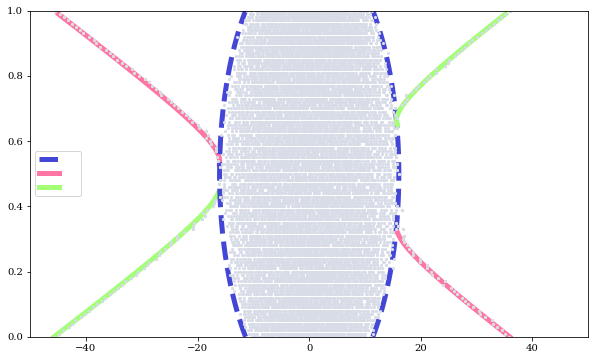

In [42]:
################################################################
############ Plot eigenvalues ##################################
################################################################

## rotated about x-axis so that p_out^- can increase
fig, ax = plt.subplots(figsize=(10, 6))
for i in range(num_rows):
    ax.scatter(e_vals[-1-i,:]-1,0.01*i*np.ones(100),s=10,edgecolors='black',c='#D7DCE7',linewidth=0.0,zorder=2)
    ax.scatter(np.max(e_vals[-1-i,:]-1),0.01*i,s=10,edgecolors='black',c='#D7DCE7',linewidth=0.001,zorder=2)
    ax.scatter(np.min(e_vals[-1-i,:]-1),0.01*i,s=10,edgecolors='black',c='#D7DCE7',linewidth=0.001,zorder=2)
#ax.plot(zf+1,prej_vec_pout_plus)
ax.plot(gamma,prej_vec_pout_plus,'--',c = '#4447D5',linewidth=5,zorder=1)

ax.plot(zf_crop1,p_out_cropf1,c = '#FF76A2',linewidth=5,zorder=1)
ax.plot(zH_crop1,p_out_cropH1,color = '#A2FF76',linewidth=5,zorder=1)
ax.plot(zf_crop2,p_out_cropf2,c = '#FF76A2',linewidth=5,zorder=1)
ax.plot(zH_crop2,p_out_cropH2,c = '#A2FF76',linewidth=5,zorder=1)

ax.plot(-gamma,prej_vec_pout_plus,'--',c = '#4447D5',linewidth=5,zorder=1)
ax.legend([' ','   ','  '],loc=6)
ax.axis([-50,50,0,1])  


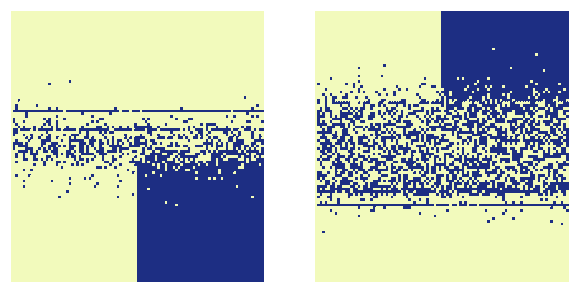

In [44]:
################################################################
######### Plot eigenvectors ####################################
################################################################

#plot eigvecs for this
fig = plt.figure(figsize=(10,5))
fig.subplots_adjust(hspace=0.3, wspace=0.2)

left = np.concatenate((e_vec_final_f2[0:51,:],e_vec_final_h2[51:,:]))
right = np.concatenate((e_vec_final_h2[0:51,:],e_vec_final_f2[51:,:]))

ax = fig.add_subplot(1, 2, 1)
#ax=sns.heatmap(e_vec_final_h2,vmin=-1, vmax=1,cmap=pal,cbar = False, xticklabels = [],yticklabels = [])
ax=sns.heatmap(left,vmin=-1, vmax=1,cmap=pal,cbar = False, xticklabels = [],yticklabels = [])

ax = fig.add_subplot(1, 2, 2)
#ax=sns.heatmap(e_vec_final_f2,vmin=-1, vmax=1,cmap=pal,cbar = False, xticklabels = [],yticklabels = [])
ax=sns.heatmap(right,vmin=-1, vmax=1,cmap=pal,cbar = False, xticklabels = [],yticklabels = [])